In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

<Figure size 1440x720 with 0 Axes>

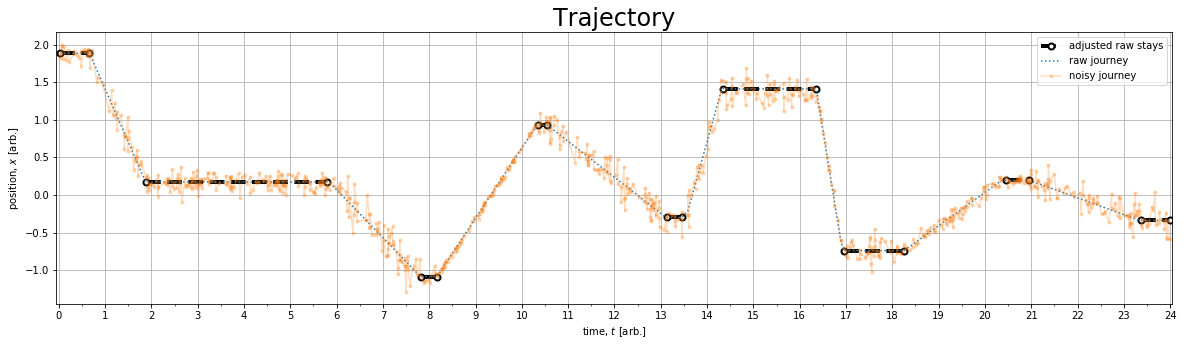

In [9]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [10]:
time_thresh = 1/6
dist_thresh=0.25

In [11]:
clusters = list(range(time_arr.size))

In [12]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [13]:
clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
len(clusters)

27

### Raw plotting

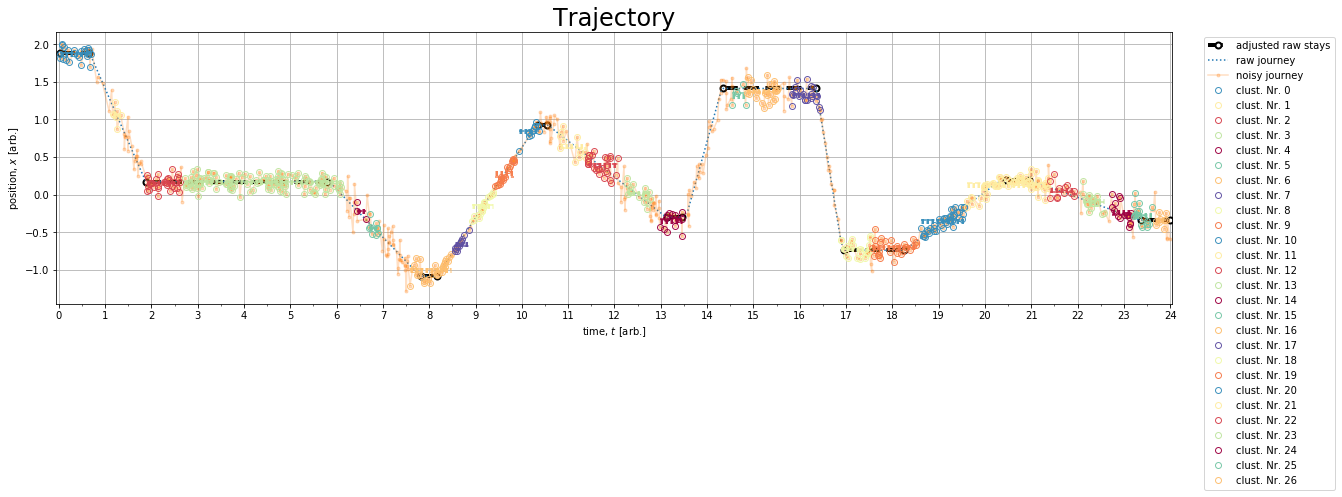

In [14]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]
    
    ax.plot(time_arr[clust], noise_arr[clust], 'o', color=color, alpha=0.95, markerfacecolor="None", label=f'clust. Nr. {cl_nr}')
    
    clust_med = np.median(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_med,clust_med], '--', color=color, alpha=0.95, label=None)
    
    clust_mean = np.mean(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_mean,clust_mean], '--', dashes=[0.5, 0.5], lw=5, color=color, alpha=0.95, label=None)
    
#ax.legend(loc=7);
cl_len = int(len(clusters)/14)
ax.legend(bbox_to_anchor=(1.15+(cl_len-1)*0.10, 1), loc='upper right', ncol=cl_len);

### IQR-plotting

In [15]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

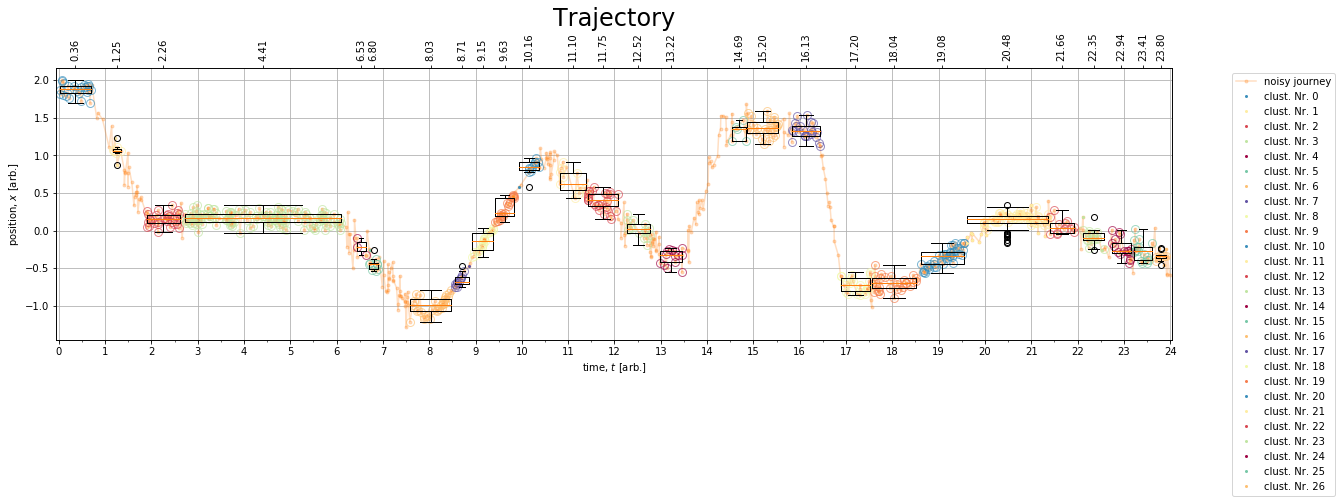

In [32]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    # Apply the "without" mask
    mask = get_iqr_mask(ys, clust, False)
    ax.plot(xs[mask], ys[mask], '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')
    
    # Apply the "within" mask    
    mask = get_iqr_mask(ys, clust, True)     
    ax.plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.65, markerfacecolor="None", label=None)

axt = ax.twiny()
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)
_ = axt.boxplot(bp_data, labels=labels, positions=positions, widths=widths)      
axt.set_xlim(ax.get_xlim())

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=True)

#ax.legend(loc=7);
cl_len = int(len(clusters)/14)
ax.legend(bbox_to_anchor=(1.15+(cl_len-1)*0.10, 1), loc='upper right', ncol=cl_len);

In [18]:
clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
len(clusters_rev)

25

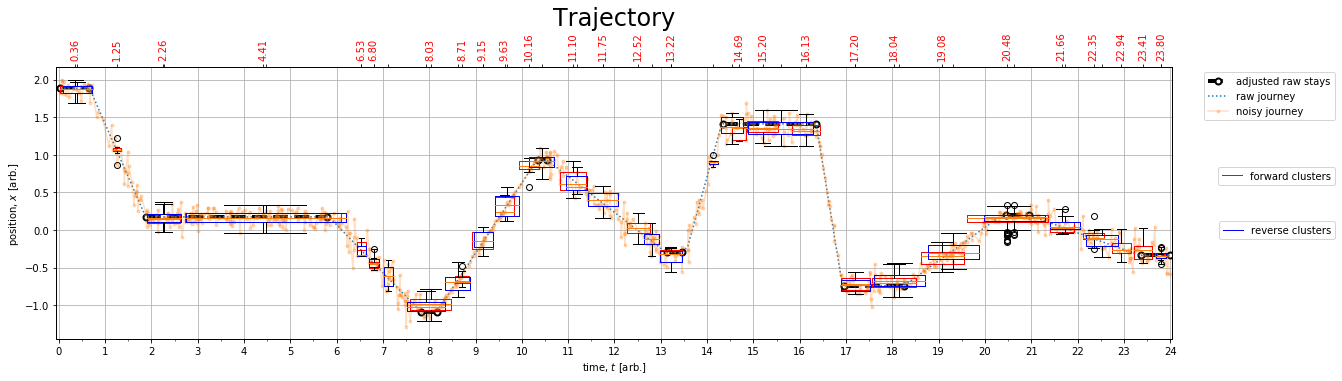

In [19]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

0.06165896077793087 -0.4294461586712821 -0.26502226326346645


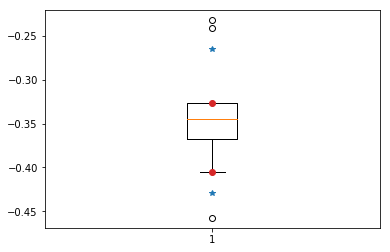

In [20]:
#clust = [446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569]
ys = noise_arr[clust]

# Mask to include only events within the IQR
q25 = np.quantile(ys,0.25, interpolation='lower')
q75 = np.quantile(ys,0.75, interpolation='higher')
iqr = abs(q75 - q25)
iqr_fact = 1.5
iqr_boost = iqr*iqr_fact
print(iqr*iqr_fact,q25-iqr_boost,q75+iqr_boost)
_ = plt.boxplot(ys)

plt.plot(1, q25-iqr_boost, 'C0*')
plt.plot(1, ys[np.where(ys > q25-iqr_boost )].min(), 'C3o')
plt.plot(1, q75+iqr_boost, 'C0*')
plt.plot(1, ys[np.where(ys < q75+iqr_boost )].max(), 'C3o')

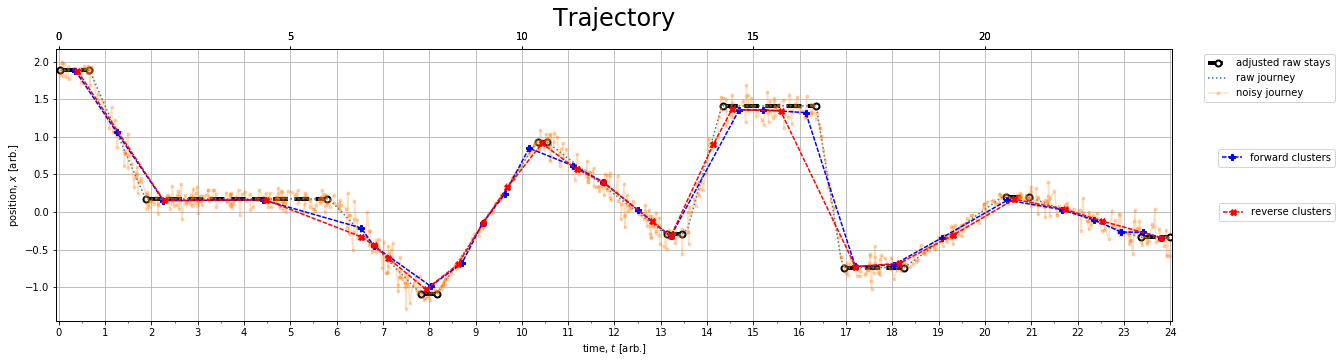

In [22]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

bp_data, positions = get_boxplot_centers(time_arr, noise_arr, clusters)
axt = ax.twiny()
_ = axt.plot(positions, bp_data,'bP--', dashes=[3,1])
axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, positions = get_boxplot_centers(time_arr[::-1], noise_arr[::-1], clusters_rev)
axt = ax.twiny()
_ = axt.plot(positions, bp_data,'rX-.', dashes=[3,1])
axt.set_xlim(ax.get_xlim())
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [23]:
from helper__metric_box__explore import get_boxplot_lines

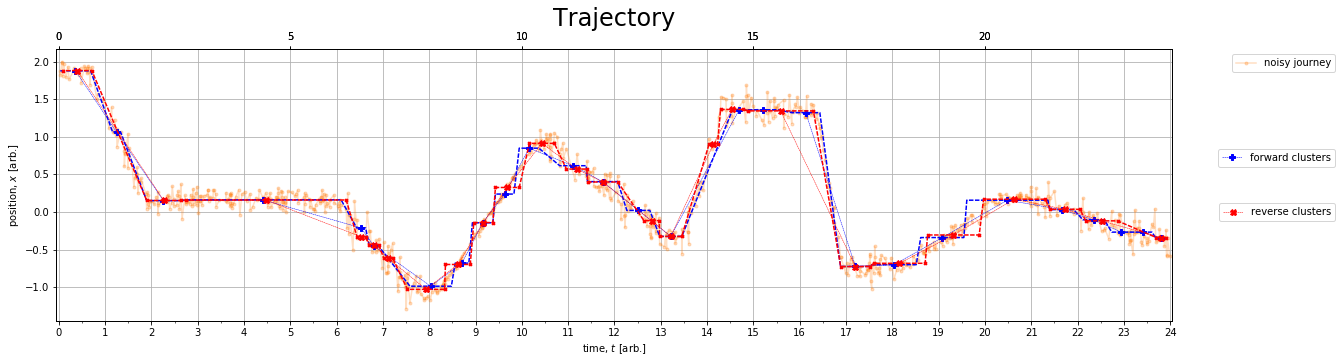

In [31]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);


axt = ax.twiny()
bp_data, positions = get_boxplot_centers(time_arr, noise_arr, clusters)
_ = axt.plot(positions, bp_data,'bP--', dashes=[3,1], lw=0.5)

bp_data, positions = get_boxplot_lines(time_arr, noise_arr, clusters)
_ = axt.plot(positions, bp_data,'b--', dashes=[3,1], lw=1.5, markersize=3.0)

axt.set_xlim(ax.get_xlim())

axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


axt = ax.twiny()
bp_data, positions = get_boxplot_centers(time_arr[::-1], noise_arr[::-1], clusters_rev)
_ = axt.plot(positions, bp_data,'rX-.', dashes=[3,1], lw=0.5)

bp_data, positions = get_boxplot_lines(time_arr[::-1], noise_arr[::-1], clusters_rev)
_ = axt.plot(positions, bp_data,'rX-.', dashes=[3,1], lw=1.5, markersize=3.0)

axt.set_xlim(ax.get_xlim())
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);